In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot
import numpy as np
import lpips
from importlib.machinery import SourceFileLoader
import glob
import cv2

from utils.save import *
from utils.utils import *

In [3]:
from models.ROLE import compute_raindrop
from models.Defence import compute_fence
from models.Dirt import compute_dirt
from train import compute_dirt_raindrop

In [4]:
ckpt_path = 'ckpts/MV_recon/'
args = json.load(open(os.path.join(ckpt_path,'args.json'),'r'))
args = AttributeDict(args)
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
param = SourceFileLoader("param", os.path.join(ckpt_path,args.param_file.split('/')[-1])).load_module()
# TODO: update path to the training data in convert_resolution()
param = convert_resolution(param,args)
args.param = param
DOE_phase = torch.load('ckpts/MV_DOE_phase.pt', map_location=args.device).detach()

In [5]:
args

{'debug': False,
 'train_optics': False,
 'pretrained_DOE': 'ckpts/MV_DOE_phase.pt',
 'pretrained_G': None,
 'result_path': '/projects/FHEIDE/obstruction_free_doe/ckpt/MV_recon',
 'param_file': 'config/param_MV_1600.py',
 'obstruction': 'dirt_raindrop',
 'sensor_noise': 0.008,
 'n_epochs': 100,
 'optics_lr': 0.1,
 'G_lr': 0.0001,
 'l1_loss_weight': 1,
 'masked_loss_weight': 1,
 'perceptual_loss_weight': 1,
 'log_freq': 400,
 'save_freq': 2000,
 'seed': 1234,
 'device': 'cuda',
 'DOE_phase_init_ckpt': 'ckpts/MV_DOE_phase.pt',
 'G_init_ckpt': None,
 'param': <module 'param' from 'ckpts/MV_recon/param_MV_1600.py'>}

In [6]:
transform_train = transforms.Compose([
        transforms.RandomCrop(param.data_resolution,pad_if_needed=True), # Places365 image size varies
        transforms.RandomCrop([param.equiv_crop_size, param.equiv_crop_size],pad_if_needed=True),
        transforms.Resize([param.img_res, param.img_res]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
        transforms.RandomCrop(param.data_resolution,pad_if_needed=True), # Places365 image size varies
        transforms.CenterCrop(param.equiv_crop_size),
        transforms.Resize([param.img_res, param.img_res]),
        transforms.ToTensor(),
    ])
if args.obstruction == 'fence':
    trainset = torchvision.datasets.Places365(
        root=param.dataset_dir, split="train-standard", transform=transform_train)
    testset = torchvision.datasets.Places365(
        root=param.dataset_dir, split="val", transform=transform_test)   
    args.compute_obstruction = compute_fence     
elif args.obstruction == 'raindrop':
    trainset = torchvision.datasets.ImageFolder(param.training_dir, transform=transform_train)
    testset = torchvision.datasets.ImageFolder(param.val_dir, transform=transform_test)
    args.compute_obstruction = compute_raindrop
elif args.obstruction == 'dirt':
    trainset = torchvision.datasets.ImageFolder(param.training_dir, transform=transform_train)
    testset = torchvision.datasets.ImageFolder(param.val_dir, transform=transform_test)
    args.compute_obstruction = compute_dirt
elif args.obstruction == 'dirt_raindrop':
    trainset = torchvision.datasets.ImageFolder(param.training_dir, transform=transform_train)
    testset = torchvision.datasets.ImageFolder(param.val_dir, transform=transform_test)
    args.compute_obstruction = compute_dirt_raindrop

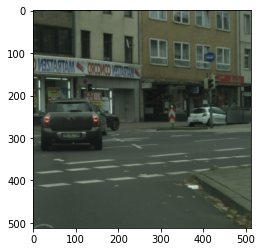

In [7]:
image_far = trainset[3][0][None,...].to(args.device)
pyplot.imshow(image_far[0].permute(1,2,0).cpu())

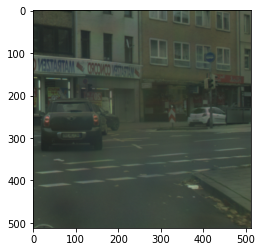

In [8]:
z_near = torch.tensor(0.05)
z_far = torch.tensor(5)
image_near, mask, image_DOE, image_near_DOE, image_far_DOE, psf_near, psf_far, mask_doe, height_map = image_formation(image_far,DOE_phase, args.compute_obstruction, args)
pyplot.imshow(image_DOE[0].permute(1,2,0).cpu())

In [ ]:
# from models.recon import Arch
# G = Arch(args).to(args.device)
# G.load_state_dict(torch.load(last_save(ckpt_path, 'G_*'), map_location=args.device))

In [ ]:
# image_recon = G(image_DOE, psf_near, psf_far)
# pyplot.imshow(image_recon[0].permute(1,2,0).cpu())